In [1]:
#必要なライブラリインポート
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

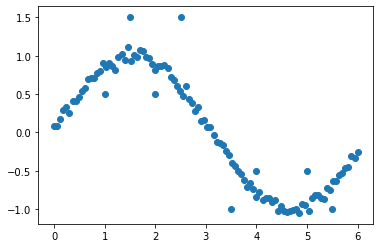

In [2]:
#適当なデータ作る
np.random.seed(0)
n = 100
X = np.linspace(0, 6, n)
y = np.sin(X) + np.random.randn(n) / 20

#外れ値入れてみる
X = np.concatenate([X, [1, 2, 4, 5, 1.5, 2.5, 3.5, 5.5]])
y = np.concatenate([y, [0.5, 0.5, -0.5, -0.5, 1.5, 1.5, -1, -1]])

#グラフ作成
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.scatter(X, y)
plt.show()

## 勾配ブースティング（自作）

勾配ブースティングに使うランダムフォレストは、scikit-learnのやつ借りる

In [3]:
from sklearn.metrics import mean_squared_error as mse #平均二乗誤差求める関数
from sklearn.ensemble import RandomForestRegressor #ランダムフォレスト

1 回目
平均二乗誤差 0.5529


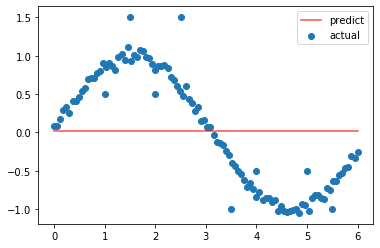

2 回目
平均二乗誤差 0.4497


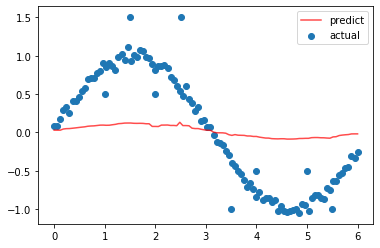

3 回目
平均二乗誤差 0.3639


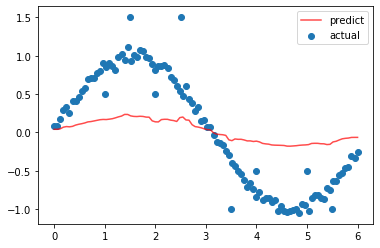

5 回目
平均二乗誤差 0.239


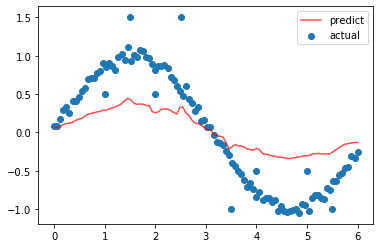

50 回目
平均二乗誤差 0.0075


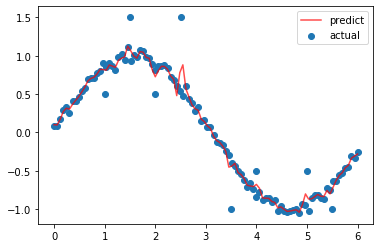

100 回目
平均二乗誤差 0.0039


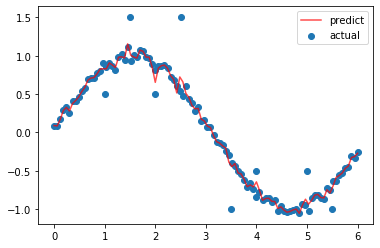

In [4]:
n = 100         #ループ回数
learn_r = 0.1  #学習率
sample_r = 0.5 #ツリー作成時のサンプル使用率

x_grid = np.linspace(min(X), max(X), 100)
model = RandomForestRegressor()

np.random.seed(0)

for i in range(n):
    #1回目は、平均を予測値とする
    if i == 0:
        y_pred = [np.mean(y) for _ in range(len(X))]
        y_grid = [np.mean(y) for _ in range(len(x_grid))]
    #2回目以降、ズレに対してランダムフォレストを作成する
    else:
        #ランダムフォレストで埋めるズレ
        target = y - y_pred
        #Xとtargetを結合し、学習に使うための一部のみ抽出する
        X_target = np.array(random.sample(list(zip(X, target)), round(len(X) * sample_r)))
        #学習
        model.fit(X_target[:, 0].reshape(-1, 1), X_target[:, 1])
        # 前回の予測に、今回のモデルを学習率掛けながら足す
        y_pred +=  learn_r * model.predict(X.reshape(-1, 1))
        y_grid +=  learn_r * model.predict(x_grid.reshape(-1, 1))
    #グラフとか表示する
    if i == 0 or i == 1 or i == 2 or i == 4 or i == 49 or i == 99:
        print(i+1, "回目")
        print("平均二乗誤差", round(mse(y, y_pred), 4))
        fig, ax = plt.subplots(1, 1)
        ax.scatter(X, y, label="actual")
        ax.plot(x_grid, y_grid, color="red", alpha=0.7, label="predict")
        ax.legend()
        plt.show()
    
# print(i+1, "回目")
# print("最小二乗誤差", mse(y, y_pred))
# fig, ax = plt.subplots(1, 1)
# ax.scatter(X, y, label="actual")
# ax.plot(x_grid, y_grid, color="red", alpha=0.7, label="predict")
# ax.legend()
# plt.show()

## 勾配ブースティング（scikit-learn）

In [5]:
from sklearn.ensemble import GradientBoostingRegressor

平均二乗誤差 0.0044


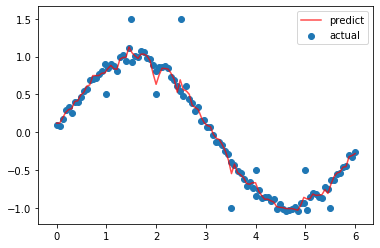

In [6]:
n = 100         #ループ回数
learn_r = 0.1  #学習率
sample_r = 0.5 #ツリー作成時のサンプル使用率

model = GradientBoostingRegressor(learning_rate=learn_r, n_estimators=n, subsample=sample_r, random_state=0)
model.fit(X.reshape(-1, 1), y)

y_pred = model.predict(X.reshape(-1, 1))
y_grid = model.predict(x_grid.reshape(-1, 1))

print("平均二乗誤差", round(mse(y, y_pred), 4))
fig, ax = plt.subplots(1, 1)
ax.plot(x_grid, y_grid, color="red", alpha=0.7, label="predict")
ax.scatter(X, y, label="actual")
ax.legend()
plt.show()

## ランダムフォレストの場合

In [7]:
from sklearn.metrics import mean_squared_error as mse #二乗誤差求める関数
from sklearn.ensemble import RandomForestRegressor #ランダムフォレスト

平均二乗誤差 0.0058


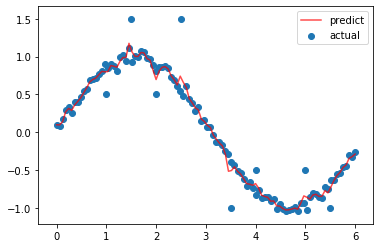

In [8]:
model = RandomForestRegressor()
model.fit(X.reshape(-1, 1), y)

y_pred = model.predict(X.reshape(-1, 1))
y_grid = model.predict(x_grid.reshape(-1, 1))

print("平均二乗誤差", round(mse(y, y_pred), 4))
fig, ax = plt.subplots(1, 1)
ax.plot(x_grid, y_grid, color="red", alpha=0.7, label="predict")
ax.scatter(X, y, label="actual")
ax.legend()
plt.show()